# Building Recognition

This is an attempt to use the techniques from Lesson 1 to recognize buildings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
np.random.seed(2)

In [4]:
bs = 64
# bs = 16

## Load and view the data

In [5]:
path = Path('../data')
path

PosixPath('../data')

In [6]:
path.ls()

[PosixPath('../data/chrysler'),
 PosixPath('../data/empire'),
 PosixPath('../data/models')]

In [7]:
tfms = get_transforms()

In [8]:
data = (ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch())

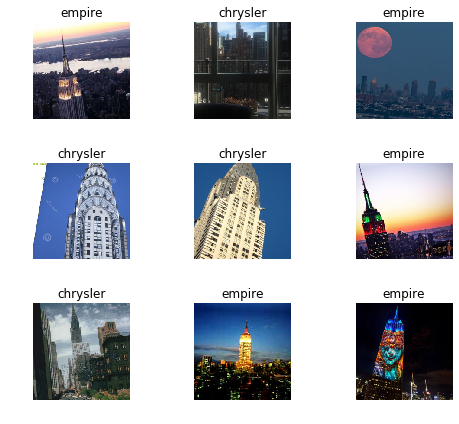

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)

['chrysler', 'empire']


## Stage 1

### Training

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.688309,0.237774,0.062069
2,0.468389,0.147324,0.041379
3,0.384685,0.151624,0.062069
4,0.324716,0.155675,0.068966


In [13]:
learn.save('stage-1')

### Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

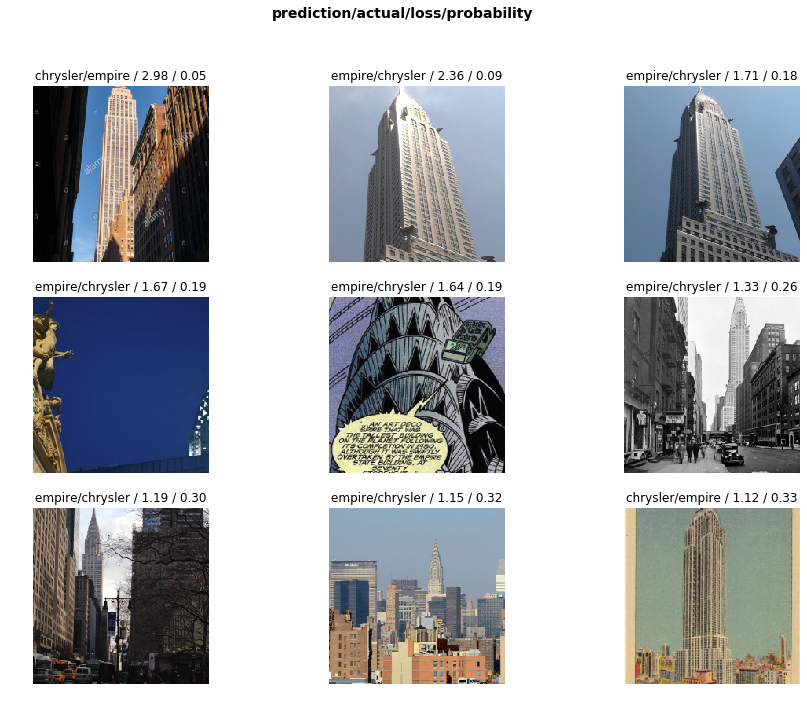

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

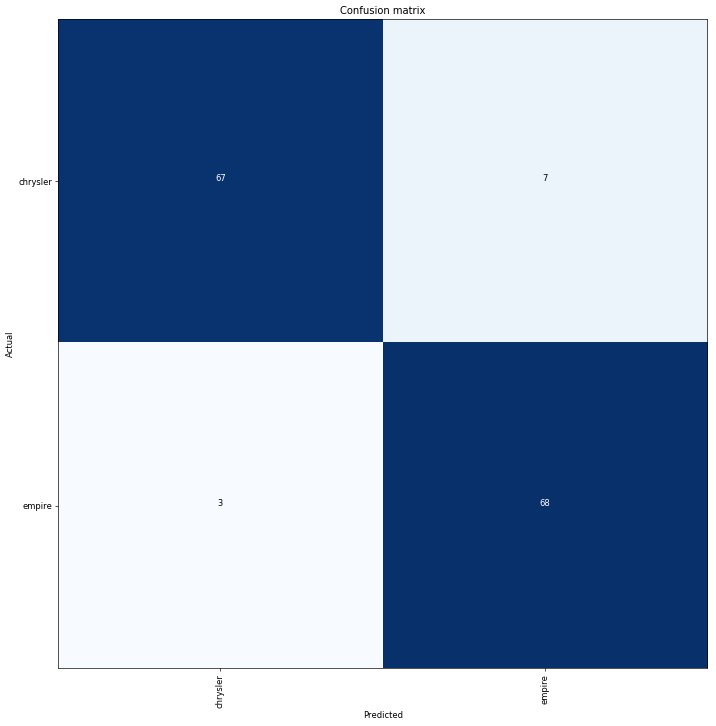

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
# interp.most_confused(min_val=2)

## Stage 2 - unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.226366,0.160293,0.068966


In [20]:
learn.load('stage-1');

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


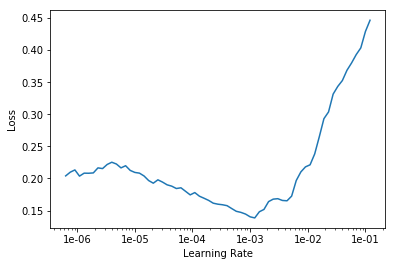

In [22]:
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.170431,0.094202,0.034483
2,0.142613,0.078473,0.020690


In [24]:
learn.save('stage-1')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

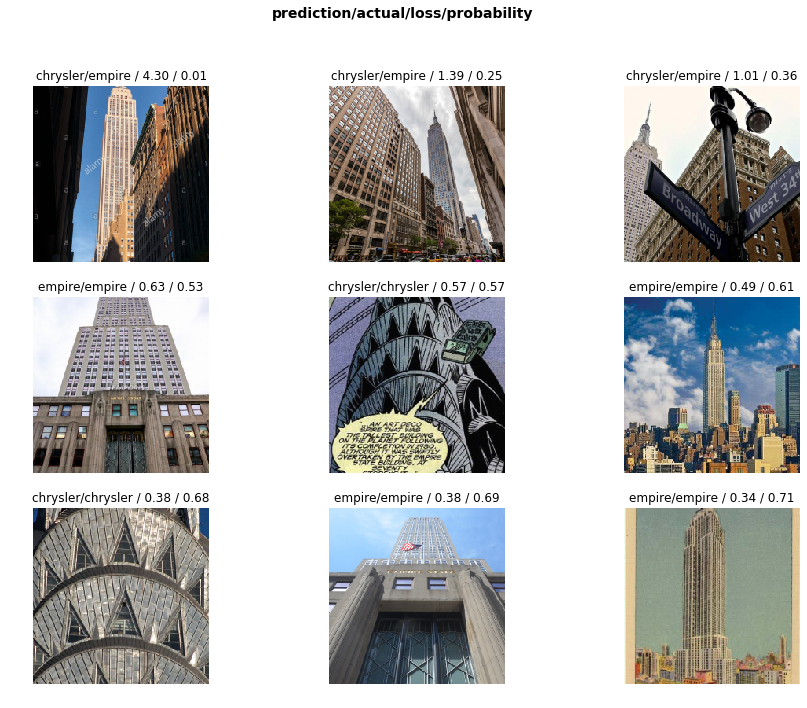

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

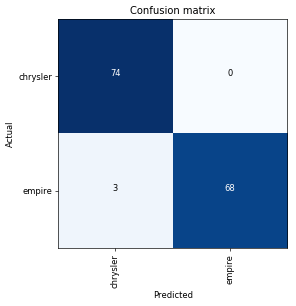

In [28]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes